In [1]:
%matplotlib inline
from utils import *
from matplotlib.patches import Polygon
import pickle
import os
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter

## Neuron params

In [2]:
# Default params
R_m = 142 * 1e6                                     # 142 MΩ
V_th = 15 * 1e-3                                    # 15 mV
tau_m = 24 * 1e-3                                   # 24 ms
f = 5                                               # 5 Hz
T = 1 / f
omega = 2 * np.pi * f                               # 5 Hz in rad/s
I_osc = 40 * 1e-12                                  # 40 pA
M = 5                                               # number of input levels
range_frac = 0.999                                  # fraction of range to use
sigma_w_avg = 0.0135                                # average sigma_w
#eta = sigma_w_to_eta(sigma_w_avg, V_th, tau_m, f)   # noise strength
eta = 0.2
#I_s = get_avg_Is(V_th, R_m, tau_m, f)
I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac)
I_s = np.linspace(I_min, I_max, 5)[1]
I_s_ref, _ = get_automatic_range(R_m, V_th, tau_m, 2*np.pi*1, I_osc, range_frac)

## A - Example of average V(t) trajectory and variance increasing with time (shaded), and slope of dV/dt at V_th

In [40]:
# Time parameters
dt = 1e-4                    # Time step for numerical integration
time = np.arange(0, 2*T, dt)

V_traj = compute_mu_V_through_time(R_m, V_th, tau_m, I_s, I_osc, f, time)
V_sigma = np.sqrt(compute_sigma_V_through_time(V_th, eta, tau_m, I_s, I_s_ref, time))

In [41]:
# Simulations

num_trials = 1000

_, v_traj, _, phi_0 = simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_s_ref, I_osc, f, M, dt, time, num_trials, True, False, True)
var_v_through_t = np.std(v_traj, axis=1)
#for v_tr in v_traj.T:
    #plt.plot(t, v_tr, color='#5D9CA2', alpha=0.2, linewidth=1)

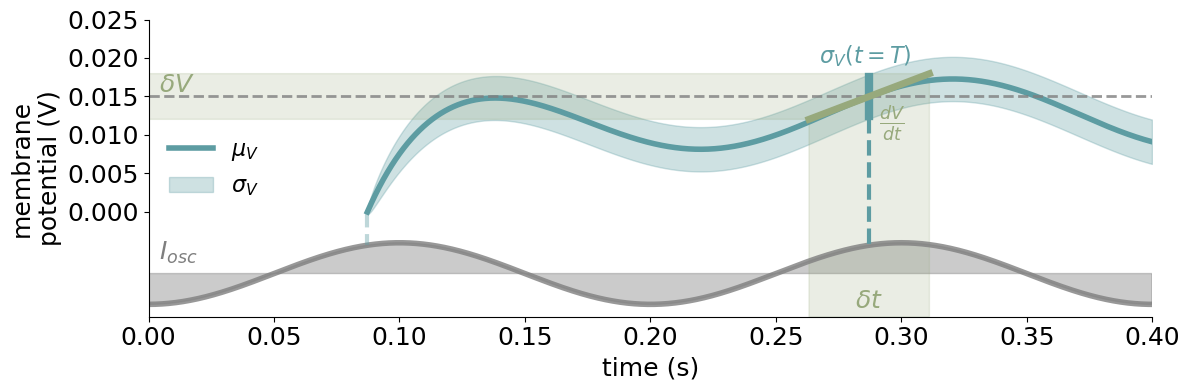

In [5]:
plt.figure(figsize=(12, 4))

dt = 1e-4

shift = -int(phi_0 / (2 * np.pi * f) / dt)
t_temp = roll_with_nan(time, shift)
plt.plot(t_temp, V_traj, color='#5D9CA2', linewidth=4, label=r'$\mu_V$')
plt.fill_between(t_temp, V_traj - V_sigma, V_traj + V_sigma, color='#5D9CA2', alpha=0.3, label=r'$\sigma_V$')

# Plot the cosine oscillation
oscillation = I_osc * np.cos(2 * np.pi * f * time - np.pi) * 1e8 - 0.008
plt.plot(time, oscillation, '-', color='#7f7f7f', alpha=0.8, linewidth=4)

# Calculate the midpoint of the oscillation
midpoint = (np.max(oscillation) + np.min(oscillation)) / 2

# Fill between the midpoint line and the cosine wave for both peaks and troughs
plt.fill_between(time, midpoint, oscillation, where=(oscillation >= midpoint), color='#7f7f7f', alpha=0.4)
plt.fill_between(time, midpoint, oscillation, where=(oscillation < midpoint), color='#7f7f7f', alpha=0.4)

phi_0_time = phi_0 / (2 * np.pi * f)
phi_0_osc_value = I_osc * np.cos(2 * np.pi * f * phi_0_time - np.pi) * 1e8 - 0.008
plt.plot([phi_0_time, phi_0_time], [0, phi_0_osc_value], color='#5D9CA2', linestyle='--', linewidth=3, alpha=0.4)
plt.plot([phi_0_time + T, phi_0_time + T], [V_th, phi_0_osc_value], color='#5D9CA2', linestyle='--', linewidth=3, alpha=1)

plt.xlim(0, 0.4)

plt.axhline(V_th, color='#7f7f7f', linestyle='--', alpha=0.8, linewidth=2)

plt.xlabel('time (s)', fontsize=18)

# Update ylabel placement
plt.ylabel('membrane\npotential (V)', fontsize=18)

# Calculate the slope at the specific point
slope = voltage_dynamics(R_m, V_th, V_th, tau_m, I_s, I_osc, f)
x0 = phi_0_time + T
y0 = V_th

# Define small intervals for dt and dV
dt = 0.024  # Adjust this value based on the scale of your plot
dV = slope * dt

# Define the color for the shaded areas
shade_alpha = 0.2
shade_color = '#97A97C'

# Get the current y-limits to restore later
current_ylim = plt.ylim()

# Vertical shaded area under the slope line, extending fully to the bottom of the plot
verts_vert = [(x0 - dt, plt.ylim()[0]), (x0 - dt, y0 - dV), (x0 + dt, y0 + dV), (x0 + dt, plt.ylim()[0])]
poly_vert = Polygon(verts_vert, color=shade_color, alpha=shade_alpha)
plt.gca().add_patch(poly_vert)

# Horizontal shaded area under the slope line
verts_horz = [(0, y0 - dV), (x0 - dt, y0 - dV), (x0 + dt, y0 + dV), (0, y0 + dV)]
poly_horz = Polygon(verts_horz, color=shade_color, alpha=shade_alpha)
plt.gca().add_patch(poly_horz)

# Add the solid vertical line at the intersection point
plt.plot([x0, x0], [y0 - V_sigma[np.argmin(np.abs(t_temp - x0))]*0.9, y0 + V_sigma[np.argmin(np.abs(t_temp - x0))]*0.9], color='#5D9CA2', linewidth=6)

# Plot the tangent line to visualize the slope, after the vertical line
x_tangent = [x0 - dt, x0 + dt]
y_tangent = [y0 - dV, y0 + dV]
plt.plot(x_tangent, y_tangent, color='#97A97C', linewidth=5)

# Restore the y-limits
plt.ylim(current_ylim)

# Add text annotations
plt.text(x0 + 0.004, y0 - 0.006, r'$\frac{dV}{dt}$', color='#97A97C', fontsize=18, verticalalignment='bottom', fontweight='bold')
plt.text(x0, plt.ylim()[0]+0.0005, r'$\delta t$', color='#97A97C', fontsize=18, horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
plt.text(0.004, y0 + dV / 2, r'$\delta V$', color='#97A97C', fontsize=18, verticalalignment='center', fontweight='bold')

# Add text for standard deviation at T
plt.text(x0 - 0.02, y0 + V_sigma[np.argmin(np.abs(t_temp - x0))]*0.9 + 0.001, r'$\sigma_V(t=T)$', color='#5D9CA2', fontsize=16, verticalalignment='bottom', fontweight='bold')

# Add text for I_osc
plt.text(0.004, midpoint + 0.001, r'$I_{osc}$', color='#7f7f7f', fontsize=18, verticalalignment='bottom', fontweight='bold')

# Update legend position and other plot settings
plt.legend(loc='center left', frameon=False, fontsize=16)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Remove y-ticks below 0
current_yticks = plt.gca().get_yticks()
new_yticks = [ytick for ytick in current_yticks if ytick >= 0]
plt.gca().set_yticks(new_yticks)

sb.despine()
plt.tight_layout()

plt.savefig('plots/fig3/fig3A_voltageTraj_with_annotations.svg', dpi=600)

plt.show()

## B - Phase distributions

In [42]:
M = 5

fs_grid = [2, 5, 10, 25, 50]
etas_grid = [0.05, 0.1, 0.2, 0.3]
alphas = np.linspace(0.2, 1, M)
c = cm.viridis(np.linspace(0, 1, M))

range_frac = 0.6
num_trials = 10000

plt.figure(figsize=(25,14), dpi=600)
count = 1
for i, eta in enumerate(etas_grid):
    for j, f in enumerate(fs_grid):
        t_end = 2 / f
        t = np.arange(0, t_end, dt)
        
        means_, variances_, all_phis, Is_range = get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac)
        
        means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N=1)
        means, variances = truncated_Gaussian_moments(means, variances, a=0)
        
        plt.subplot(4,5,count)
        for k, Is in enumerate(Is_range):
            x, y = Gaussian_pdf(means[k], np.sqrt(variances[k]))
            plt.plot(x, y, linewidth=3, linestyle='-', color=c[k], label=str(int(Is*1e12))+" pA")
            plt.hist(all_phis[k], bins='auto', density=True, color=c[k], alpha=.4, edgecolor=c[k])
        
        plt.title(r"$\eta = $" + str(eta) + r", $f = $" + str(f), fontsize=16, fontweight='bold')
        plt.legend(frameon=False, fontsize=12)
        if i == 3: 
            plt.xlabel('$\mathit{\phi}$ (rad)', fontsize=18, fontweight='bold')
        if j == 0:
            plt.ylabel('p.d.f.', fontsize=18, fontweight='bold')
        plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=18)
        #plt.xlim(-np.pi/2, (5/2)*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 4)
        plt.yticks(fontsize=18)
        sb.despine()
        count+=1
        
plt.tight_layout()

plt.savefig('plots/fig3/fig3B_phase_distribs.svg', dpi=600)

plt.show()

C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


## C - MSE in variance

In [3]:
def load_data(file_path):
    with open(file_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

# Specify the directory containing the pickle files
directory = 'Data_2/'

# Initialize lists to store the aggregated data
means_theo = []
variances_theo = []
means_emp = []
variances_emp = []
MI = []

# Loop through all files in the specified directory
for filename in os.listdir(directory):
    if filename.endswith('.pickle'):
        file_path = os.path.join(directory, filename)
        data = load_data(file_path)
        
        means_theo.append(data["means_theo"])
        variances_theo.append(data["variances_theo"])
        means_emp.append(data["means_emp"])
        variances_emp.append(data["variances_emp"])
        MI.append(data["MI"])

# Convert lists to full matrices (numpy arrays)
means_theo = np.array(means_theo)
variances_theo = np.array(variances_theo)
means_emp = np.array(means_emp)
variances_emp = np.array(variances_emp)
MI = np.array(MI)

In [4]:
res = 200
means_theo = means_theo.reshape(res, res, 10)
variances_theo = variances_theo.reshape(res, res, 10)
means_emp = means_emp.reshape(res, res, 10)
variances_emp = variances_emp.reshape(res, res, 10)
MI = MI.reshape(res, res)

In [5]:
# Display the shapes of the full matrices
print(f"means_theo_matrix shape: {means_theo.shape}")
print(f"variances_theo_matrix shape: {variances_theo.shape}")
print(f"means_emp_matrix shape: {means_emp.shape}")
print(f"variances_emp_matrix shape: {variances_emp.shape}")
print(f"MI_matrix shape: {MI.shape}")

means_theo_matrix shape: (200, 200, 10)
variances_theo_matrix shape: (200, 200, 10)
means_emp_matrix shape: (200, 200, 10)
variances_emp_matrix shape: (200, 200, 10)
MI_matrix shape: (200, 200)


In [6]:
avg_var_emp = np.mean(variances_emp, axis=2)
std_var_emp = np.std(variances_emp, axis=2)
avg_var_theo = np.mean(variances_theo, axis=2) 
std_var_theo = np.std(variances_theo, axis=2)
mse_vars = np.mean((variances_emp - variances_theo)**2, axis=2)

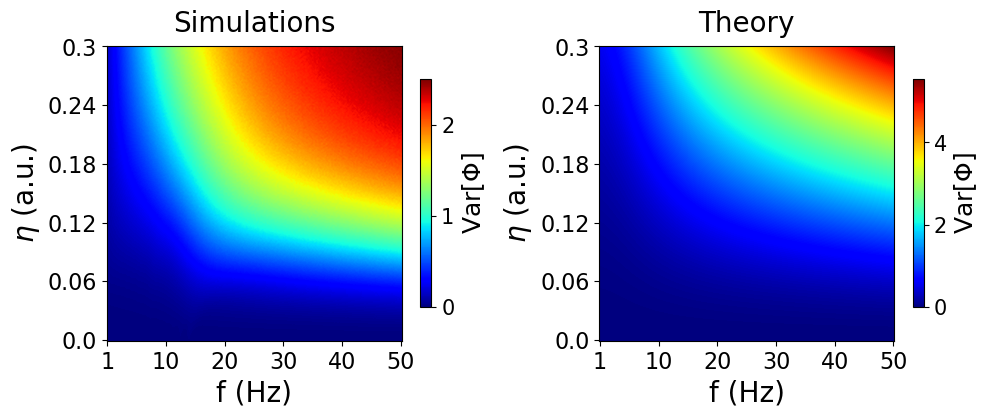

In [52]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Simulations', fontsize=20, pad=10)
img1 = plt.imshow(avg_var_emp, origin='lower', cmap='jet', vmin=0, interpolation='lanczos')
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.001, 0.3, 6).round(2), fontsize=16)
plt.xlabel('f (Hz)', fontsize=20)
plt.ylabel('$\eta$ (a.u.)', fontsize=20)
cbar = plt.colorbar(img1, label='Var[$\Phi$]', shrink=.5)
cbar.set_label('Var[$\Phi$]', fontsize=18)
cbar.ax.tick_params(labelsize=15)  # Increase colorbar tick fontsize


plt.subplot(122)
plt.title('Theory', fontsize=20, pad=10)
img2 = plt.imshow(avg_var_theo, origin='lower', cmap='jet', vmin=0, interpolation='lanczos')
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.001, 0.3, 6).round(2), fontsize=16)
plt.xlabel('f (Hz)', fontsize=20)
plt.ylabel('$\eta$ (a.u.)', fontsize=20)
cbar = plt.colorbar(img2, label='Var[$\Phi$]', shrink=.5)
cbar.set_label('Var[$\Phi$]', fontsize=18)
cbar.ax.tick_params(labelsize=15)  # Increase colorbar tick fontsize


plt.tight_layout()

#plt.savefig('plots/info_rate_approx.png', dpi=600)

plt.show()

### With same scale:

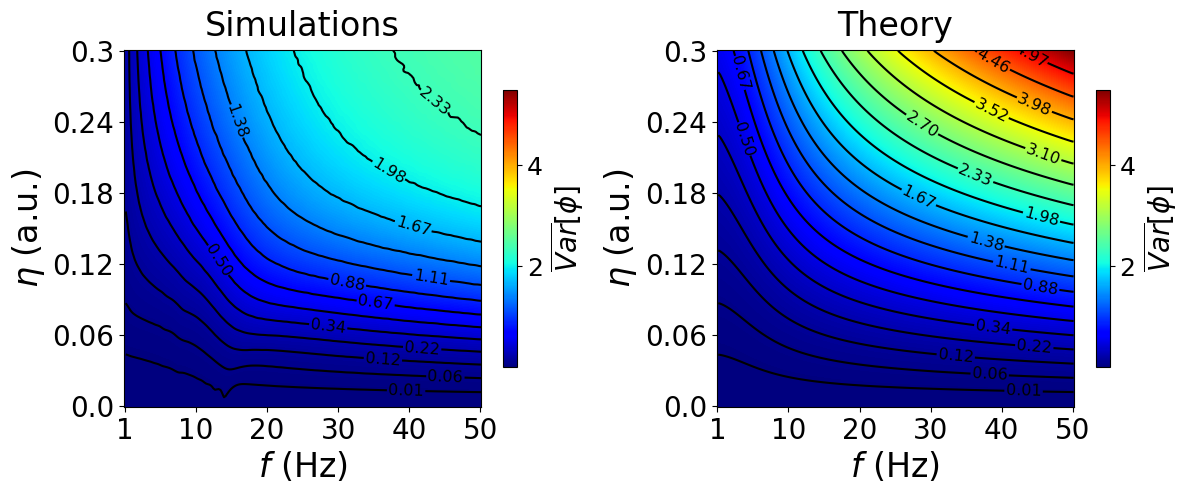

In [33]:
# Apply Gaussian smoothing to the data
sigma = 1  # Standard deviation for Gaussian kernel, adjust as needed
avg_var_emp_smooth = gaussian_filter(avg_var_emp, sigma=sigma)
avg_var_theo_smooth = gaussian_filter(avg_var_theo, sigma=sigma)

# Determine the common color scale range
vmin = min(np.min(avg_var_emp_smooth), np.min(avg_var_theo_smooth))
vmax = max(np.max(avg_var_emp_smooth), np.max(avg_var_theo_smooth))

# Define contour levels using a power law
num_levels = 21
power = 2  # Adjust power to control spacing between levels
contour_levels = np.linspace(0, 1, num=num_levels)**power * (vmax - vmin) + vmin

plt.figure(figsize=(12, 6))

# Simulations plot
plt.subplot(121)
plt.title('Simulations', fontsize=24, pad=10)
img1 = plt.imshow(avg_var_emp_smooth, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours1 = plt.contour(avg_var_emp_smooth, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.001, 0.3, 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=24)
plt.ylabel('$\eta$ (a.u.)', fontsize=24)
cbar = plt.colorbar(img1, label='$\overline{Var}[\phi]$', shrink=.5)
cbar.set_label('$\overline{Var}[\phi]$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize

# Theory plot
plt.subplot(122)
plt.title('Theory', fontsize=24, pad=10)
img2 = plt.imshow(avg_var_theo_smooth, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours2 = plt.contour(avg_var_theo_smooth, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours2, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.001, 0.3, 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=24)
plt.ylabel('$\eta$ (a.u.)', fontsize=24)
cbar = plt.colorbar(img2, label='$\overline{Var}[\phi]$', shrink=.5)
cbar.set_label('$\overline{Var}[\phi]$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize

plt.tight_layout()

plt.savefig('plots/fig3/fig3C_varianceEstim.svg', dpi=600)

plt.show()

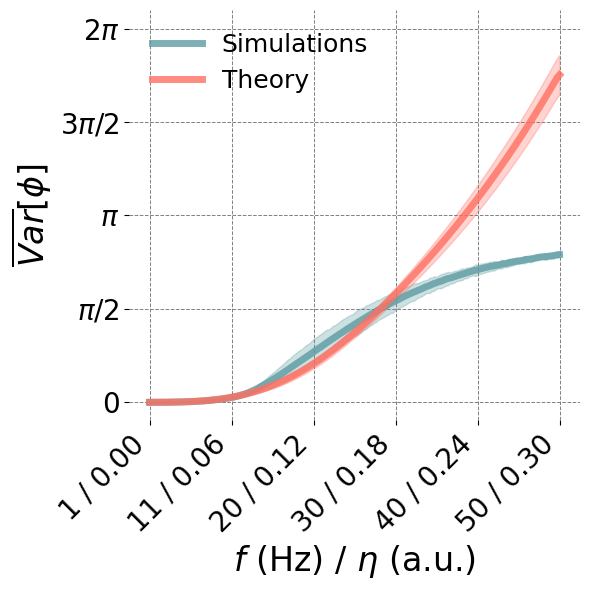

In [49]:
# Extract the diagonal elements
diag_emp = np.diagonal(avg_var_emp_smooth)
diag_theo = np.diagonal(avg_var_theo_smooth)
diag_emp_std = np.diagonal(std_var_emp)
diag_theo_std = np.diagonal(std_var_theo)
diag_length = len(diag_emp)

# Create x-axis values for the diagonal slice corresponding to both f and eta
f_values = np.linspace(1, 50, res)  # Frequency range
eta_values = np.linspace(0.001, 0.3, res)  # Eta range

# Create labels combining f and eta values
x_labels = [f'{f:.0f} / {eta:.2f}' for f, eta in zip(f_values, eta_values)]

# Create a new figure for the diagonal slices
plt.figure(figsize=(6, 6))
plt.plot(diag_emp, label='Simulations', color='#5D9CA2', linewidth=5, alpha=0.8)
plt.plot(diag_theo, label='Theory', color='#FF6F61', linewidth=5, alpha=0.8)

# Add the standard deviations as shaded areas
plt.fill_between(range(diag_length), diag_emp - diag_emp_std, diag_emp + diag_emp_std, color='#5D9CA2', alpha=0.3)
plt.fill_between(range(diag_length), diag_theo - diag_theo_std, diag_theo + diag_theo_std, color='#FF6F61', alpha=0.3)

plt.xlabel('$f$ (Hz) / $\eta$ (a.u.)', fontsize=24)
plt.ylabel('$\overline{Var}[\phi]$', fontsize=24)
plt.xticks(np.linspace(0, diag_length-1, 6), [x_labels[i] for i in np.linspace(0, diag_length-1, 6).astype(int)], fontsize=20, rotation=45, ha='right')
plt.yticks(np.linspace(0, 2*np.pi, 5), [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'], fontsize=20)
plt.legend(fontsize=18, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')

# Remove all axes lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.ylim(-0.3, 2*np.pi*1.05)

plt.tight_layout()

plt.savefig('plots/fig3/fig3C_diagonalSlices.svg', dpi=600)

plt.show()

## MSE

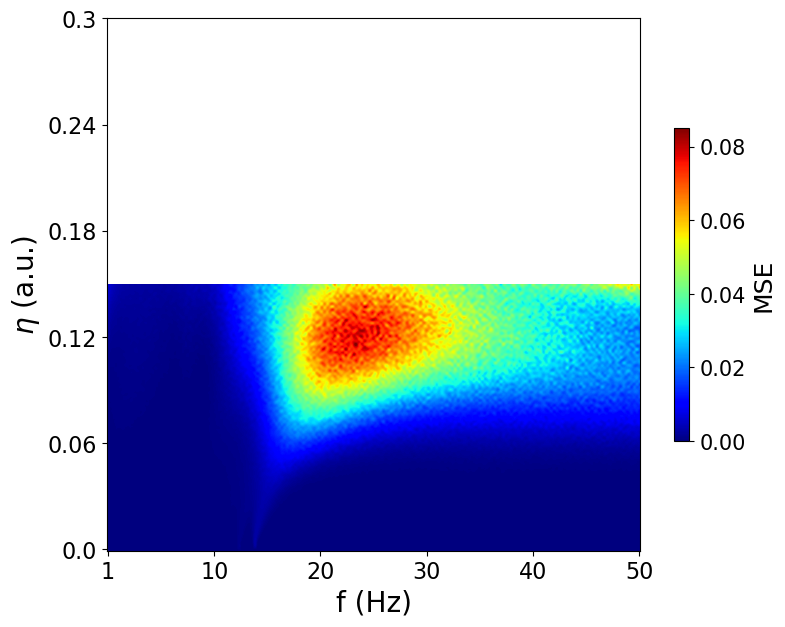

In [39]:
plt.figure(figsize=(8,7))

#norm = mcolors.LogNorm(vmin=mse_vars[mse_vars > 0].min(), vmax=mse_vars.max())

#plt.title('Simulations', fontsize=20, pad=10)
img1 = plt.imshow(mse_vars[:100,:], origin='lower', cmap='jet', interpolation='lanczos')
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.001, 0.3, 6).round(2), fontsize=16)
plt.xlabel('f (Hz)', fontsize=20)
plt.ylabel('$\eta$ (a.u.)', fontsize=20)
cbar = plt.colorbar(img1, label='MSE', shrink=.5)
cbar.set_label('MSE', fontsize=18)
cbar.ax.tick_params(labelsize=15)  # Increase colorbar tick fontsize


plt.tight_layout()

#plt.savefig('plots/info_rate_approx.png', dpi=600)

plt.show()